# Sequential cluster test on fMRI data

In [1]:
from nibabel.nifti1 import Nifti1Image
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import load_img
from nilearn import plotting
from nilearn import datasets
from matplotlib import pyplot as plt
import numpy as np

from niseq import sequential_cluster_test_1samp

Let's say that we are willing to collect $n_\text{max} = 80$ subjects, but we want to check if we have enough evidence to stop early every 10 subjects. Let's load in some data.

In [2]:
def get_data(n_subjects):
    '''
    Fetches the first `n` first-level contrast maps from the 
    calculation task in the Brainomics localizer dataset.
    Specifically, the "calculation (auditory and visual cue)"
    contrast is used.
    
    Arguments
    -----------
    n_subjects : int
        number of subjects to fetch
    
    Returns
    ----------
    X : array of shape (n_subjects, ...)
        The first-level contrast map for each subject.
        Voxels outside of brain mask are NaN.
    affine : array
        Indicates the position of the image array data in a 
        reference space, which we'll use for plotting.
    '''
    localizer_dataset = datasets.fetch_localizer_calculation_task(
        n_subjects = n_subjects, legacy_format = False
    )
    cmap_filenames = localizer_dataset.cmaps
    imgs = [load_img(f) for f in cmap_filenames]
    X = np.stack([img.get_fdata() for img in imgs])
    return X, imgs[0].affine

In [3]:
X, affine = get_data(10)
X.shape

(10, 53, 63, 46)

Great, we've "collected" our first 10 subjects. It's time to do the first of our sequential tests.

To run any sequential test, you have to tell `niseq` a few things about your design:
1. The maximum sample size. (We said above that this would be `n_max = 80`.)
2. The sample sizes at which you've analyzed the data _so far._ (We're looking at the data for the first time, so we'd specify `look_times = [10]`.)
3. The number of permutations to use. In a permutation test, the smallest possible $p$-value you can obtain is $1/n_{\text{permutations}}$, so make sure you use enough permutations to reject the null at the first adjusted alpha, which is the value of your spending function at the first interim analysis. (Here, we'll use 5,000.)
4. __Optional:__ A chosen signficance level $\alpha$ and an alpha spending function. If you don't pick anything, the spending function will be linear with $\alpha = 0.05$ by default. (Here, we'll use $\alpha = 0.01$, and we'll go with the default linear spending function, so need need to specify that in the function call.)

And, importantly, __you must input your data in the order in which it was collected.__ That means that the array you input (in our case, `X`) has to be ordered along the first (index 0) axis.

Specific to this cluster-based test, we also need to input:
1. An (arbitrary) clustering threshold, which says how large a _t_-value needs to be to get included in a cluster. (We'll pick `t_thres = 3`, which is pretty low relative to the thresholds you see in the literature, but in principle this doesn't affect our false positive rate.)
2. A brain mask, so `niseq` knows which voxels to ignore. 
3. __Not used here:__ An adjacency matrix, which says which voxels/measurements are next to each other. fMRI data like this lives on a 3D grid, so we can let `niseq` assume lattice adjacency by default. But if we were working with surface data or M/EEG data, this would be necessary.

In [4]:
## study design params
# sequential params
n_max = 80
look_times = [10]
# our chosen false positive rate
alpha = 0.01
# how many permuations should we do?
n_perm = 5000

## cluster test params
# t-stat threshold for a voxel to be included in a cluster
t_thres = 3
# brain mask
not_brain = np.any(~np.isfinite(X), axis = 0)

obs_stats, ps, adj_alpha, spending = sequential_cluster_test_1samp(
    X, look_times, n_max, 
    alpha = alpha, 
    threshold = t_thres, 
    exclude = not_brain, 
    n_permutations = n_perm,
    seed = 0,
    n_jobs = -1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1026 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1674 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2466 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 3402 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 4482 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   50.9s finished


***
**Usage note:** The `exclude` argument can be used to apply a brain mask (or rather, a "not brain" mask to be consistent with the MNE-Python API). Here, voxels outside the brain are `NaN`, so we can just mask with `np.any(~np.isfinite(X), axis = 0)`, but if you're working with your own data, you probably have a brain mask stored separately. 
***

In [5]:
def print_results(look_times, ps, adj_alpha):
    reject = ps <= adj_alpha
    for n, p, alpha in zip(look_times, ps, adj_alpha):
        msg = 'with p = %.5f and adjusted alpha = %.5f'%(p, alpha)
        if p <= alpha:
            print('rejected null at n = %d'%n, msg)
        else:
            print('failed to reject null at n = %d'%n, msg)
            
print_results(look_times, ps, adj_alpha)

failed to reject null at n = 10 with p = 0.00760 and adjusted alpha = 0.00125


Looks like we don't quite have enough evidence to reject the null hypothesis, given our design. So we'll "collect" 10 more subjects as planned, and run our sequential analysis again. 

In [6]:
# "collect" 10 more subjects so we have 20 observations
X, _ = get_data(20)

Remember, `look_times` should contain _every_ sample size at which we analyzed the data; otherwise, `niseq` won't have the information it needs to compute adjusted $\alpha$'s. So it should __not__ be `look_times = [20]`, but instead it should be `look_times = [10, 20]`. Or you can just append the new look time to the existing list as we do in the following code chunk.

In [7]:
# update look times
look_times.append(20)

# run the next sequential test
obs_stats, ps, adj_alpha, spending = sequential_cluster_test_1samp(
    X, look_times, n_max, 
    alpha = alpha, 
    threshold = t_thres, 
    exclude = not_brain, 
    seed = 0,
    n_permutations = n_perm,
    n_jobs = -1
)
print_results(look_times, ps, adj_alpha)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 882 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1278 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1746 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 2286 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 2898 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3582 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4338 tasks      | elapsed:  1.5min


failed to reject null at n = 10 with p = 0.00760 and adjusted alpha = 0.00125
rejected null at n = 20 with p = 0.00020 and adjusted alpha = 0.00240


[Parallel(n_jobs=-1)]: Done 4995 out of 5000 | elapsed:  1.8min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.8min finished


This time, we rejected the null hypothesis! 

Now let's plot the clusters that were stronger than chance. 

/home/johnv/anaconda3/envs/niseq/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


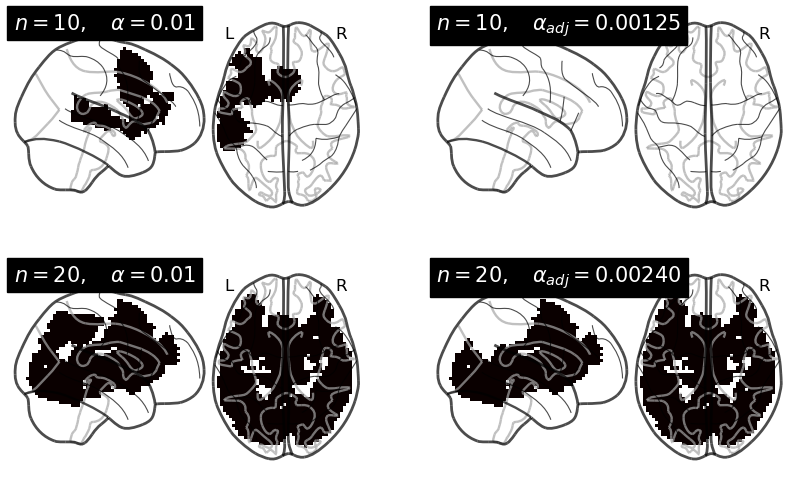

In [8]:
def plot_brain(t_obs, mask, ax, title = None, affine = affine, plot_t = False):
    if plot_t: # plot masked t-map
        t_map = Nifti1Image(t_obs * mask, affine) 
        plotting.plot_glass_brain(
            t_map, title = title,
            display_mode = 'xz', 
            axes = ax
        )
    else: # plot clusters
        clusts = Nifti1Image(mask.astype(float), affine)
        plotting.plot_glass_brain(
            clusts, title = title,
            display_mode = 'xz', 
            axes = ax
        )
    
def get_cluster_mask(t_obs, clusters, cluster_pv, alpha):
    sig_clusts = [clust for i, clust in enumerate(clusters) if cluster_pv[i] <= alpha]
    if len(sig_clusts) > 0:
        cluster_mask = np.any(np.stack(sig_clusts), axis = 0)
    else:
        cluster_mask = np.zeros_like(t_obs)
    return cluster_mask
    
def plot_results(n, res, alpha, adj_alpha, axs):
    t_obs, clusters, cluster_pv, H0 = res
    mask_uncorr = get_cluster_mask(t_obs, clusters, cluster_pv, alpha)
    plot_brain(
        t_obs, mask_uncorr, 
        axs[0], title = r'$n = %d,\quad\alpha = %.2f$'%(n, alpha)
    )
    mask_corr = get_cluster_mask(t_obs, clusters, cluster_pv, adj_alpha)
    plot_brain(
        t_obs, mask_corr, 
        axs[1], title = r'$n = %d,\quad\alpha_{adj} = %.5f$'%(n, adj_alpha)
    )

def plot_all_results(look_times, obs_stats, alpha, adj_alpha):
    fig, axs = plt.subplots(len(look_times), 2, figsize = (10, 3 * len(look_times)))
    for i, n in enumerate(look_times):
        plot_results(n, obs_stats[n], alpha, adj_alpha[i], axs[i])
    return fig

plot_all_results(look_times, obs_stats, alpha, adj_alpha)
plt.show()

We could stop here, at just 25% of our specified maximum sample size, since we've already accured enough evidence to reject the null. However, we don't _have_ to stop. Usually, many brain areas are activated by a given cognitive task, but alpha spending allows you to reject the "whole brain" null hypothesis after finding just one cluster that's stronger than chance. By stopping data collection early, you run the risk of missing real, though weaker, signals in other parts of the brain. At $n = 20$, for instance, you can see that there's a parietal cluster in the uncorrected map that didn't survive in the corrected map, which may or may not represent real brain activity. 

Of course, you _also_ run that risk by running fixed-sample designs with arbitrary sample sizes, so I wouldn't say that's a disadvantage of the sequential approach per se. In fact, the sequential approach, unlike the fixed sample approach, allows us to keep going! (At least up until our pre-specified $n_\max$.) Let's collect 10 more subjects and see what happens. 

In [9]:
X, _ = get_data(30)
look_times.append(30)

obs_stats, ps, adj_alpha, spending = sequential_cluster_test_1samp(
    X, look_times, n_max, 
    alpha = alpha, 
    threshold = t_thres, 
    exclude = not_brain, 
    seed = 0,
    n_permutations = n_perm,
    n_jobs = -1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1146 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1452 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 1794 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2172 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2586 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3036 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3522 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4044 tasks      | ela

/home/johnv/anaconda3/envs/niseq/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


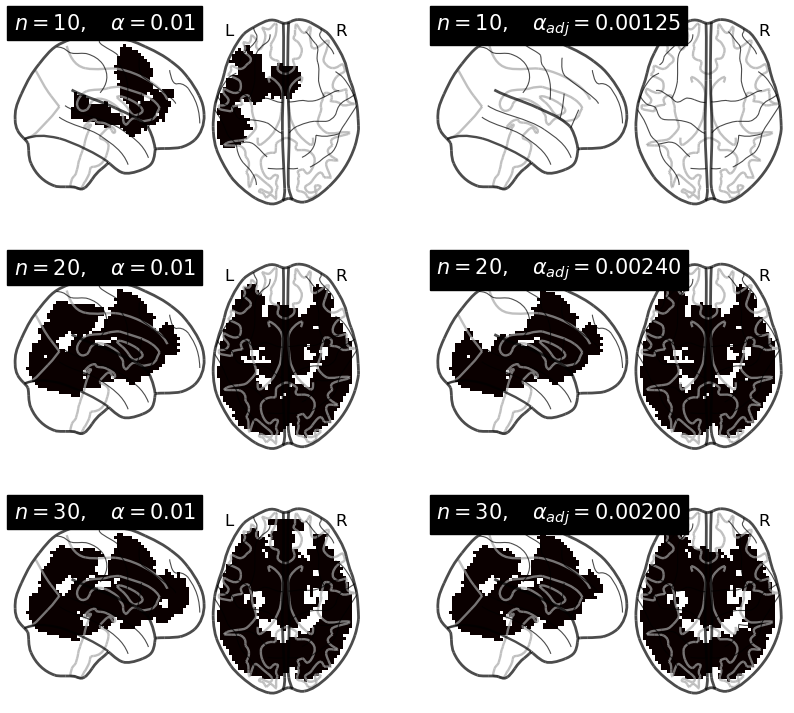

In [10]:
plot_all_results(look_times, obs_stats, alpha, adj_alpha)
plt.savefig('fmri-example.jpeg', dpi = 500)
plt.show()